# !Link to challenge!

# https://www.kaggle.com/t/4cab4f6367c44d1a9a8a9769d8e36e57

# Set CUDA variables

^C


In [8]:
%env CUDA_VISIBLE_DEVICES=0
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys

env: CUDA_VISIBLE_DEVICES=0
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [1]:
!nvidia-smi

Wed Jan 31 16:40:36 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.48                 Driver Version: 367.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 6713:00:00.0     Off |                    0 |
| N/A   64C    P0   114W / 149W |   6730MiB / 11439MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 7AEC:00:00.0     Off |                    0 |
| N/A   83C    P0    76W / 149W |   6731MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### import standard packages

In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## import torch and h5 data format parser

In [3]:
import h5py
import torch

## Read data function.

- with nb_events you can choose how many examples you want to download.
- np.rollaxis(hit_map, 3, 1) change the axis order to put channels first. This is the format of pytorch framework.
- (hit_map - hit_map.mean ...  All examples are being standartized: substracted a mean and divided by std. deviation. This is done for each channels separatly.

In [4]:
train = h5py.File('/data/ICL2018_kaggle_2/kaggle_train.h5', 'r')
test = h5py.File('/data/ICL2018_kaggle_2/kaggle_test.h5', 'r')

In [5]:
print(train['all_events']['histHCAL'].shape)
print(test['all_events']['histHCAL'].shape)

(412416, 64, 64)
(137471, 64, 64)


In [6]:
def read_data(data, is_train=True, nb_events=None):
    layer_hcal = np.expand_dims(data['all_events']['histHCAL'][:nb_events], -1)
    layer_em = np.expand_dims(data['all_events']['histEM'][:nb_events], -1)
    layer_track = np.expand_dims(data['all_events']['histtrack'][:nb_events], -1)
    
    hit_map = np.concatenate((layer_hcal, layer_em, layer_track), axis=-1)
    hit_map = np.rollaxis(hit_map, 3, 1)
    hit_map = (hit_map - hit_map.mean(axis=0, keepdims=True)) / hit_map.std(axis=0, keepdims=True)
    answers = None
    if is_train:
        answers = np.expand_dims(data['all_events']['y'][:nb_events], -1)
    return hit_map, answers

In [ ]:
X_train, y_train = read_data(train, is_train=True, nb_events=200000)
assert (X_train.shape[0] == y_train.shape[0])
print(X_train.shape)

In [48]:
X_test = None
X_train = None
y_train = None
X_val = None
y_val = None
y_pred = None
y_predicted = None

In [8]:
#print(y_train.shape)
print(y_train[5])

NameError: name 'y_train' is not defined

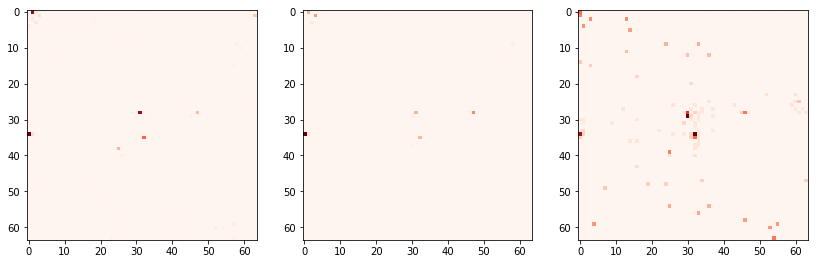

In [10]:
f, ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    ax[i].imshow(X_train[100,i,:,:], cmap="Reds")

### As usual split the train data to train and validation samples.

In [9]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.95, random_state=42)

## The next steps are exactly the same as was on cifar seminar to Tuesday

In [12]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### This is dummy example of CNN, look what you can change here(HINT: look at cifar seminar cheatsheet)

In [12]:
model = torch.nn.Sequential()
model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 32, kernel_size=(5,5), stride=1, padding=0))
model.add_module("maxpool_2", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", torch.nn.ReLU())

model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(6272, 128))
model.add_module("relu_2", torch.nn.ReLU())
model.add_module("fc2", torch.nn.Linear(128, 1))
model.add_module("sigmoid", torch.nn.Sigmoid())

model

Sequential(
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_1): Conv2d (3, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (relu_1): ReLU()
  (flat): Flatten(
  )
  (fc1): Linear(in_features=6272, out_features=128)
  (relu_2): ReLU()
  (fc2): Linear(in_features=128, out_features=1)
  (sigmoid): Sigmoid()
)

In [11]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(64))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(64, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(32))
model.add_module("relu_2", nn.ReLU())
model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))


model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(5408, 128))
model.add_module("relu_3", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

Sequential (
  (conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (dropout_1): Dropout2d (p=0.1)
  (relu_1): ReLU ()
  (maxpool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU ()
  (maxpool_2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (flat): Flatten (
  )
  (fc1): Linear (5408 -> 128)
  (relu_3): ReLU ()
  (fc2): Linear (128 -> 1)
  (sigmoid): Sigmoid ()
)

In [12]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(3,3), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(64))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(64, 48, kernel_size=(3,3), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(48))
model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(48, 32, kernel_size=(3,3), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(32))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_3", nn.ReLU())
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))


model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(1152, 128))
model.add_module("relu_4", nn.Tanh())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

Sequential (
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (dropout_1): Dropout2d (p=0.1)
  (relu_1): ReLU ()
  (maxpool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
  (dropout_2): Dropout2d (p=0.1)
  (relu_2): ReLU ()
  (maxpool_2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (dropout_3): Dropout2d (p=0.1)
  (relu_3): ReLU ()
  (maxpool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (flat): Flatten (
  )
  (fc1): Linear (1152 -> 128)
  (relu_4): Tanh ()
  (fc2): Linear (128 -> 1)
  (sigmoid): Sigmoid ()
)

In [ ]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(64))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(64, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(64))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(64, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(32))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_3", nn.ReLU())
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_4', nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(32))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(32))
model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_5", nn.ReLU())
model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))




model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(288, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

In [16]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 128, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(128))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(128, 96, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(96))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(96, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(64))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_3", nn.ReLU())
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_4', nn.Conv2d(64, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(32))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(32))
model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_5", nn.ReLU())
model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))




model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(288, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

Sequential (
  (conv_1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (dropout_1): Dropout2d (p=0.1)
  (relu_1): ReLU ()
  (maxpool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2): Conv2d(128, 96, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU ()
  (conv_3): Conv2d(96, 64, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (dropout_3): Dropout2d (p=0.1)
  (relu_3): ReLU ()
  (maxpool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_4): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (relu_4): ReLU ()
  (conv_5): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (dropout_4): Dropout2d (p=0.1)

In [70]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 256, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(256))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(256, 128, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(128))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(128, 96, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(96))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_3", nn.ReLU())
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_4', nn.Conv2d(96, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(64))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(64, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(64))
model.add_module('dropout_5', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_5", nn.ReLU())
model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))




model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(576, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

Sequential (
  (conv_1): Conv2d(3, 256, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (dropout_1): Dropout2d (p=0.1)
  (relu_1): ReLU ()
  (maxpool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU ()
  (conv_3): Conv2d(128, 96, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (dropout_3): Dropout2d (p=0.1)
  (relu_3): ReLU ()
  (maxpool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_4): Conv2d(96, 64, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu_4): ReLU ()
  (conv_5): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (dropout_5): Dropout2d (p=0

In [13]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 128, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(128))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_1", nn.ReLU())
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_2', nn.Conv2d(128, 96, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(96))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(96, 64, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(64))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_3", nn.ReLU())
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_4', nn.Conv2d(64, 32, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(32))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(32, 32, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(32))
model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_5", nn.ReLU())
#model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))




model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(288, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

Sequential (
  (conv_1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (dropout_1): Dropout2d (p=0.1)
  (relu_1): ReLU ()
  (maxpool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2): Conv2d(128, 96, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm_2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU ()
  (conv_3): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (dropout_3): Dropout2d (p=0.1)
  (relu_3): ReLU ()
  (maxpool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (relu_4): ReLU ()
  (conv_5): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm_5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (dropout_4): Dropout2d (p=0.1)

In [ ]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 128, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(128))
#model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", nn.ReLU())


model.add_module('conv_2', nn.Conv2d(128, 96, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(96))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(96, 64, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(64))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_3", nn.ReLU())


model.add_module('conv_4', nn.Conv2d(64, 48, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(48))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(48, 48, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(48))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_5", nn.ReLU())
#model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))




model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(432, 128))
model.add_module("relu_6", nn.Tanh())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

In [ ]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(64))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", nn.ReLU())


model.add_module('conv_2', nn.Conv2d(64, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(64))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(64, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(32))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_3", nn.ReLU())


model.add_module('conv_5', nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(32))
model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=4))
model.add_module("relu_5", nn.ReLU())





model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(128, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

In [ ]:
model = torch.nn.Sequential()
#model.add_module("maxpool_11", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 256, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_1', nn.BatchNorm2d(256))
model.add_module('dropout_1', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", nn.ReLU())

model.add_module('conv_2', nn.Conv2d(256, 192, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_2', nn.BatchNorm2d(192))
#model.add_module('dropout_2', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_2", nn.ReLU())
#model.add_module("maxpool_2", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_3', nn.Conv2d(192, 128, kernel_size=(5,5), stride=1, padding=0))
model.add_module('batchnorm_3', nn.BatchNorm2d(128))
model.add_module('dropout_3', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_3", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_3", nn.ReLU())

model.add_module('conv_4', nn.Conv2d(128, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_4', nn.BatchNorm2d(64))
#model.add_module('dropout_4', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("relu_4", nn.ReLU())
#model.add_module("maxpool_4", nn.MaxPool2d(kernel_size=2))

model.add_module('conv_5', nn.Conv2d(64, 64, kernel_size=(4,4), stride=1, padding=0))
model.add_module('batchnorm_5', nn.BatchNorm2d(64))
model.add_module('dropout_5', nn.Dropout2d(p=0.1, inplace=False))
model.add_module("maxpool_5", nn.MaxPool2d(kernel_size=2))
model.add_module("relu_5", nn.ReLU())





model.add_module("flat", Flatten())

model.add_module("fc1", nn.Linear(256, 128))
model.add_module("relu_6", nn.ReLU())
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

model.cuda(0)

### Training on minibatches

Just like before, we train our model on small random minibatches of data with adaptive optimization method of your choice.

In [14]:
# An auxilary function that returns mini-batches for neural network training
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

### Choose you optimiser

In [15]:
#opt = torch.optim.SGD(model.parameters(), lr=0.005)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

## And set up batch_size and number of epochs

In [16]:
import time
from pandas import ewma
from IPython import display

num_epochs = 4 #amount of passes through the data
batch_size = 209 #number of samples processed at each function call
auc_history = []

In [20]:
num_epochs = 1

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


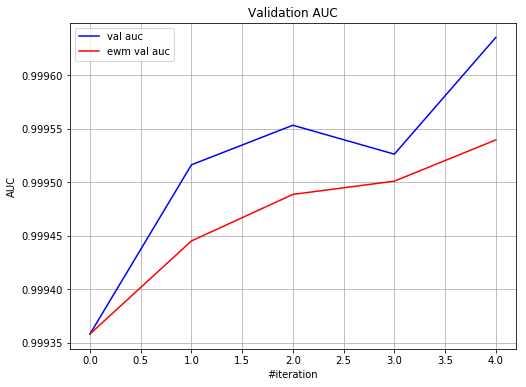

Epoch 1 of 1 took 1681.332s
  training loss (in-iteration):		0.030592
  train accuracy:		98.90 %
  validation accuracy:		99.18 %
  validation roc_auc:		99.96 %


In [21]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    
    train_err = train_acc = 0
    start_time = time.time()
    
    # This is you have see already - traning loop
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_batch = Variable(torch.FloatTensor(y_batch)).cuda(0)
        
        y_predicted = model(X_batch)
        loss = torch.nn.functional.binary_cross_entropy(y_predicted, y_batch).mean()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_err += loss.data.cpu().numpy()[0]
        train_acc += torch.eq(torch.round(y_predicted), y_batch).data.cpu().numpy().mean()

    # And a full pass over the validation data:
    y_pred = []
    
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_pred.extend(model(X_batch).data.cpu().numpy())
        
    y_pred = np.asarray(y_pred)
    # Save the metrics values   
    val_acc = accuracy_score(y_val, y_pred > 0.5)
    val_roc_auc = roc_auc_score(y_val, y_pred)
    auc_history.append(val_roc_auc)

    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Validation AUC")
    plt.xlabel("#iteration")
    plt.ylabel("AUC")
    plt.plot(auc_history, 'b',label='val auc')
    plt.plot(ewma(np.array(auc_history), span=10),'r',label='ewm val auc')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    train_batches = np.ceil(len(X_train) // batch_size)
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc * 100))
    print("  validation roc_auc:\t\t{:.2f} %".format(val_roc_auc * 100))

# Read test data, feed it to neural network, and save the output in kaggle fromat.

In [30]:
print(val_roc_auc * 100)

99.9635325074


In [39]:
X_train = None
y_train = None

In [40]:
X_test, non_var = read_data(test, is_train=False)
dummy_y = np.array(range(len(X_test)))

In [41]:
model.train(False)
y_pred = []
for X_batch, y_batch in iterate_minibatches(X_test, dummy_y, batch_size, shuffle=False):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
    y_pred.extend(model(X_batch).data.cpu().numpy())

y_predicted = np.asarray(y_pred)

100%|██████████| 658/658 [10:47<00:00,  1.02it/s]


Saving you results to file.

In [42]:
import pandas as pd
from IPython.display import FileLink

def save_results(filename, y_ans):
    answer_dataframe = pd.DataFrame(columns=["ID", "ans"])
    answer_dataframe['ID'] = range(0,len(y_ans))
    answer_dataframe['ans'] = y_ans
    answer_dataframe.to_csv('{}'.format(filename), index=False)
    return FileLink('{}'.format(filename))

In [43]:
save_results("baseline06.csv", y_predicted)

/home/user28/Hossein/MLatImperial2018/06_lab/baseline06.csv